# Latent dirichlet allocation (LDA)

I identify the topics discussed in each school webside blurb using Latent dirichlet allocation (LDA). LDA is a mixed membership model. Mixed memership models allow us to associate a given data point with a set of different cluster assignments and to capture the relative proportion of different clusters in a datapoint.

## Load packages and data

Read in packages and data.

In [5]:
from py_files.importing_packages import *
import random
import gensim
import json
import numpy as np
import pandas as pd
import gensim
from gensim import corpora
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download()   # modules I (possibly) need are averaged_perceptro n_tagger, 
# maxent_treebank_pos_tagger, punkt, stopwords, wordnet 
# (running locally on my mac, will open a new window (you need to close it before can continue)

%matplotlib inline

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> averaged_perceptron_tagger
        /home/ec2-user/nltk_data...
      Unzipping taggers/averaged_perceptron_tagger.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [16]:
df = pd.read_csv('../my_datasets/prepped.csv')
print len(df)

4676


Get list of URNs (will need later when put it back together) and blurbs

In [17]:
urn_series = df["urn"]
blist = df["blurb"].tolist()

## Preprocess data

Before fitting my LDA model, I need to break each blurb into individual elements that can serve as features. In addition to tokenizing (breaking up each blurb) I will perform a number of steps, in the following order (although note that there are multiple ways in which these operations could be combined):
<ol>
<li>**Remove all non-ASCII characters**: eg. \xe2\x80\x98</li>
<li>**Make all words lowercase**</li>
<li>**Remove punctuation**</li>
<li>**Tokenize**: divide string into a list of substrings.</li>
<li>**Remove words not containing letters**</li>
<li>**Remove words containing numbers**</li>
<li>**Remove short words**: that is, of 3 characters or less.</li>
<li>**Remove NLTK stopwords**: stopwords are a list of high frequency words like, the, to, and also.</li>
<li>**Get parts of speech**: performed using [NLTK’s Treebank maximum entropy classifier](http://nltk.org/api/nltk.classify.html) based pos tagger. This is a slow but accurate pos tagger that was originally trained on the [Treebank](http://en.wikipedia.org/wiki/Treebank) corpus. Ideally, we would have used a classifier that was trained on our school website text, but I decided to take this faster approach as a first cut. Most topic models are built using nouns as they are most representative of concrete topics. Although adjectives, verbs and other parts of speech can add interesting context, they generally overpower the underlying nouns and can inject sentiment.</li>
<li>**Lemmatize**: using [NLTK’s WordNet Lemmatizer](http://nltk.org/_modules/nltk/stem/wordnet.html). This reduces the dimensions of the data even further by aggregating words that either are the same root or have the same meaning.  The lemmatizer uses the pos tags to understand what words might be synonyms.  The lemmatizer would take a word such as *teacher* and *teachers* and make sure both were just *teacher*. I used lematization rather than stemming, as stemmers can aggressively mangle words.</li>
<li>**Remove custom stopwords**: I drop a set of custom stopwords, that is, stopwords that, based on looking at the top words in each topic, I think that it was not helpful to include.</li>
</ol>

In [18]:
## Remove all non-ASCII characters from blurbs (eg. \xe2\x80\x98)
new_list = []
for b in blist:
    new_list.append(b.decode('utf8').encode('ascii', errors='ignore'))
blist = new_list

## Create lists of stopwords 
nltk_stoplist = nltk.corpus.stopwords.words('english')
custom_stoplist = []
# custom_stoplist = ['child', 'children', 'pupil', 'student', 'princip', 'headteach',
#                    'parent', 'staff', 'peopl','governor','head','teacher',
#                    'girl','boy', 'age','young', 
#                    'communiti', 'free', 'primari', 'sixth', 'colleg', 'england',
#                    'george','king','infant','nurseri','junior',
#                    'websit', 'pleas','thank','interest', 'link', 'like', 'page', 'click', 
#                    'find', 'contact','inform', 'look', 'news', 'newslett','visit',
#                    'form', 'twitter','site','telephon','message','email','updat','blog',
#                    'septemb', 'februari','march','week', 'year','term', 'date','time','monday',
#                    'would', 'everi', 'make', 'look', 'come', 'well', 'area',
#                    'togeth', 'need', 'give', 'also', 'use', 'offic', 'keep',
#                    'know', 'posit','rang','feder', 'around','part','follow',
#                    'take','includ','nation',
#                    'provid', 'build', 'offer', 'work', 'educ', 'learn',
#                    'event','polici','class','hope','best','good','high',
#                    'cathol', 'church', 'villag','lot','back',
#                    'copi','view','detail','life']  

def no_punctuation_unicode(text):
    # remove puncuation from text
    '''converts unicode -> string, applies .translate,
    and then converts it back'''
    str_text = str(text)
    no_punctuation = str_text.translate(None, string.punctuation)
    unicode_text = no_punctuation.decode('utf-8')
    return unicode_text

def hasNumbers(inputString):
    # check if inputString contains numbers   
    return any(char.isdigit() for char in inputString)

# Instantiate a WordNet Lemmatizer
wnl = WordNetLemmatizer()
        
# Will need to convert penn_tag to morphy_tag used by WordNet Lemmatizer
# http://stackoverflow.com/questions/5364493/lemmatizing-pos-tagged-words-with-nltk
morphy_tag = {'NN':wordnet.NOUN,'JJ':wordnet.ADJ,'VB':wordnet.VERB,'RB':wordnet.ADV}
        
def prep_blurb(blurb):
    blurb = blurb.lower()  # make lowercase
    blurb = no_punctuation_unicode(blurb) # remove punctuation
    blurb = nltk.word_tokenize(blurb) # tokenize  
    blurb = [t for t in blurb if re.search('[a-zA-Z]',t)] # remove words not containing letters
    blurb = [t for t in blurb if not hasNumbers(t)] # remove words containing numbers
    blurb = [t for t in blurb if len(t)>3]  # remove short words
    blurb = [t for t in blurb if not t in nltk_stoplist]  #remove nltk stopwords
    blurb = [word for word in nltk.pos_tag(blurb)]  # get parts of speech
    blurb = [word for word in blurb if word[1] in ['NN','NNS']]  # reduce to only nouns
    blurb = [wnl.lemmatize(word[0],morphy_tag[word[1][:2]]) for word in blurb]  # lemmatize
    blurb = [t for t in blurb if len(t)>3]  # remove short words a second time in case introduced by lemmatization
    blurb = [t for t in blurb if not t in nltk_stoplist] # remove nltk stopwords a second time in case introduced by lemmatization
    blurb = [t for t in blurb if not t in custom_stoplist]  # remove custom stopwords 
    return blurb

prepped_list = []
for b in blist:
    prepped_list.append(prep_blurb(b)) 

# for i in range(5):
#     print prepped_list[i]

I next turn my tokenized, stemmed etc. blurbs into an id-term dictionary. The Dictionary() function traverses texts, assigning a unique integer id to each unique token while also collecting word counts 

In [19]:
my_dict = corpora.Dictionary(prepped_list)

I then remove infrequent and frequent words by using the dictionary.filter_extremes() method. I remove all words that appear in at least 5 documents, removed all words that appeared in more than 60% of the documents.

In [20]:
print len(my_dict)
my_dict.filter_extremes(no_below=5, no_above=0.6, keep_n=None)
print len(my_dict)
print my_dict.keys()[:30]
print my_dict[1]

8466
1729
[0, 1, 2, 3, 4, 5, 871, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 875, 25, 26, 27, 28, 29]
similarity


The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples: (term ID, term frequency). 

In [21]:
corpus = [my_dict.doc2bow(text) for text in prepped_list]
print len(corpus)
print corpus[0]

4676
[(27, 1), (119, 1), (221, 1), (292, 1), (397, 1), (400, 1), (782, 1), (841, 1), (888, 1), (921, 1), (1065, 1), (1133, 1), (1148, 1), (1167, 1), (1194, 1), (1307, 1)]


I am going to run my LDA models on EC2. I therefore need to save my dictionary and corpus

In [22]:
my_dict.save('../data/lda_dictionary.dict')
corpora.MmCorpus.serialize('../data/lda_corpus.mm', corpus)

Check that I am able to load the dictionary and corpus without introducing changes from the original

In [23]:
test_dictionary = corpora.Dictionary.load('../data/lda_dictionary.dict')
print test_dictionary.keys()[:30]
print test_dictionary[1]

test_corpus = corpora.MmCorpus('../data/lda_corpus.mm')
print test_corpus[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
similarity
[(27, 1.0), (119, 1.0), (221, 1.0), (292, 1.0), (397, 1.0), (400, 1.0), (782, 1.0), (841, 1.0), (888, 1.0), (921, 1.0), (1065, 1.0), (1133, 1.0), (1148, 1.0), (1167, 1.0), (1194, 1.0), (1307, 1.0)]


## Brief overview of LDA

Here, I briefly discuss the LDA model and inference using this model. For further details, David Blei has an [excellent couple of talks](http://videolectures.net/mlss09uk_blei_tm/) introducing topic modelling, and LDA in particular.

### Probabalistic generative model

LDA assumes that there are some number k of topics that live outside of the document collection. Each topic is a distribution over the entire fixed vocabulary of v words (that is, a vector that assigns a probability to every word in teh vocabulary). The topics (the distributions over words) follow a v-dimensional Dirichlet distribution : $\beta_k \sim Dir(\eta)$. 

If you haven't seen it before, don't be confused by the fact that the Dirichlet is a distribution of distributions. Each draw from the Dirichlet assigns a probability to each element of a vector (whose length is determined by the dimensinoality of the Dirichlet), and these vectors of probabilities (which in our case we call topics) follow a Dichlet distribution. 

LDA posits the following data generation process:

For each document, d
<ol>
<li>Draw a distribution over all k topics from the Dirichlet distribution: $\theta_d \sim Dir(\alpha)$. (Again, each individual draw is a vector of probabilities over all k topics, and these vectors follow a Dirichlet distribution). 
<li>For each word, n, in the document:
<ol>
<li>Draw a topic assignment from a multinomial distribution with the parameters you drew in (1): $Z_{d,n} \sim Multi(\theta_d).$ Use this to select the corresponding topic, $\beta_{z_{d,n}}$, from the topic matrix.
<li>Draw a word from the topic that you selected in (2a): $w_{d,n} \sim \beta_{z_{d,n}}$
</ol>
</ol>

### Computation (inferring hidden variables from the data)

The only variable form the above model that we actually get to observe is the words W_{d,n}. We need to infer the latent (hidden) variables in the model from the data; specifically, we need to infer:
<li>per-word topic assignments: $z_{d,n}$</li>
<li>per-document topic proportions: $\theta_d$</li>
<li>per-corpus topic distributions: $\beta_k$</li>

LDA is a hierarchical Bayesian model: a statistical model written in multiple levels that estimates the parameters of the posterior distribution using the Bayesian method. In this case, the posterior is the distribution of the hidden variables given the observations (words). 

Unfortunately, this posterior is intractable to compute. Therefore, we appeal to approximate posterior inference of the posterior (that is, we need a method that will infer an approximation of the posterior distribution). There are a variety of methods for doing this:
<li>Gibbs sampling</li>
<li>variational methods</li>
<li>per-corpus topic distributions: $\beta_k$</li>

### Setting up our model and algorithm

There a number of things that we may want to explore varying in setting up our model (this list is not exhaustive, for example, we might also explore which n-grams to include in our bag of words):
<ul>
<li>number of topics, k
<li>model hyperparameters (paramaters of the prior distributions)
<ul>
<li>$\alpha$ - influences document-topic density: with a higher alpha documents are like to be made up of a mixture of most of the topics, and not any single topic specifically. A low alpha value puts less such constraints on documents and means that it is more likely that a document may contain mixture of just a few, or even only one, of the topics. To visualize this, assume a symetric distribution (only one value for alpha) and that there are three topics (so alpha is of length three, and each draw from the Dirichlet is a vecotr of length three). If alpha is greater than 1 there will be a peak to the distribution over vectors centered at $E[\theta_i|\alpha]$. The higher the value of alpha, the more peaky this distribution, that is, the more probability each draw assigns to vectors near the mean, and the less to other vectors (notably, vectors in the conresr that put a lot of weight on just one topic. 
<li>$\eta$ - similarly influence topic-word density: a high beta-value means that each topic is likely to contain a mixture of most of the words, and not any word specifically, while a low value means that a topic may contain a mixture of just a few of the words..
</ul>
</ul>

In addition, we could experiment with different algorithms in training our LDA model.

## Fit initial LDA model

I fit my LDA model using gensim, which implements LDA using [online variational Bayes](https://rare-technologies.com/tutorial-on-mallet-in-python/). I run gensim on EC2 using a m4.2xlarge instance type, and use gensim's [ldamulticore](https://radimrehurek.com/gensim/models/ldamulticore.html) to parellize the model training across the instance's eight cores.

I include the following parameters in the LDA model:
<ul>
<li>num_topics: *required.* An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
<li>id2word: *required.* The LdaModel class requires our previous dictionary to map ids to strings.
<li>passes: *optional.* The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.
<li>workers: the number of extra processes to use for parallelization. Uses all available cores by default (so don't actually include this - just go with the default).
<li>chunksize: the number of documents to sent to each worker. It uses 2000 by default, so instead I send it int(float(len(my_corpus))/my_workers), where my_workers is the number of cores.
</ul>

In [24]:
# To see output as code is running, uncomment line below
# import logging
# logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.INFO)

my_workers = 8

data_directory = '../data/'
my_dict = corpora.Dictionary.load(data_directory + 'lda_dictionary.dict')
my_corpus = corpora.MmCorpus(data_directory + 'lda_corpus.mm')

my_chunksize = int(float(len(my_corpus))/my_workers)
my_lda = gensim.models.LdaMulticore(my_corpus, num_topics=6, id2word=my_dict, passes=20, workers=my_workers, chunksize=my_chunksize)
my_lda.save('../results/first_lda.lda')

I then read in the results and take a look.

In [25]:
test_lda = gensim.models.LdaModel.load('../results/first_lda.lda')

# With LDA, a topic is a probability distribution over words in the vocabulary; that is, each 
# topic assigns a particular probability to every one of the unique words that appears in our 
# data. Different topics will assign different probabilities to the same word. 
# Next, therefore, let's look at the highest probability words in each topic, which will give 
# us a sense of its major themes.
topic_list = test_lda.print_topics(num_topics=6, num_words=8)
for t in topic_list:
    print t[1]
print
    
# Take a look at the topic proportions for each blurb 
for row in range(3): 
    print test_lda[corpus[row]]

# Convert topic proportions for each blurb (gensim.interfaces.TransformedCorpus object)
# to list of lists (nb. length of topic proportion lists may vary across topics, because 
# doesn't report very small proportions)
# results_list = []
# for row in range(len(corpus)):
#     results_list.append(lda[corpus[row]])

# Write list of lists to json
# with open('lda_blurb_topics.txt','w') as myfile:
#     json.dump(results_list, myfile)

0.056*"year" + 0.050*"student" + 0.027*"principal" + 0.020*"college" + 0.018*"term" + 0.017*"academy" + 0.016*"result" + 0.013*"parent"
0.050*"church" + 0.036*"community" + 0.020*"value" + 0.018*"england" + 0.016*"village" + 0.016*"life" + 0.015*"heart" + 0.015*"parent"
0.049*"year" + 0.025*"class" + 0.017*"area" + 0.017*"parent" + 0.015*"curriculum" + 0.015*"information" + 0.014*"sport" + 0.014*"community"
0.037*"community" + 0.022*"life" + 0.021*"information" + 0.021*"parent" + 0.018*"value" + 0.018*"visit" + 0.018*"staff" + 0.017*"website"
0.036*"parent" + 0.034*"information" + 0.030*"please" + 0.029*"staff" + 0.022*"visit" + 0.021*"pupil" + 0.018*"hope" + 0.018*"community"
0.030*"student" + 0.027*"community" + 0.020*"pupil" + 0.020*"staff" + 0.019*"education" + 0.018*"environment" + 0.018*"opportunity" + 0.017*"academy"

[(3, 0.51895881717116521), (4, 0.44153533345985507)]
[(1, 0.77401782837958222), (2, 0.20107173686321486)]
[(3, 0.14843251172365707), (5, 0.82912129652319422)]


## Choose the number of topics

To compare the performance of models with different parameter values I use per-word perpelexity, folowing [Blie et al. (2003)](http://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf). Perplexity is a measure of the likelihood achieved on a held-out test set. A lower perplexity indicates better performance. 

I begin by calculating the perplexity of models with different numbers of topics.

In [47]:
# Set the different numbers of topics that I will try
num_topic_list = range(2, 52, 10)

# Set number of cores to use when running gensim
my_workers=8

# Read in dictionary and corpus
my_dictionary = corpora.Dictionary.load('../data/lda_dictionary.dict')
my_corpus = corpora.MmCorpus('../data/lda_corpus.mm')

# Split into 80% training and 20% test sets
cp = list(my_corpus)
random.shuffle(cp)
p = int(len(cp) * .8)
train_corpus = cp[0:p]
test_corpus = cp[p:]
print 'Size training set:', len(train_corpus)
print 'Size test test:', len(test_corpus) 

# Compute perplexities for different numbers of topics
perplexities = []
my_chunksize = int(float(len(my_corpus))/my_workers)
number_of_words = sum(cnt for document in test_corpus for _, cnt in document)
for n in num_topic_list:
    model = gensim.models.LdaMulticore(corpus=train_corpus, num_topics=n, id2word=my_dictionary, 
                                       workers=my_workers, chunksize=my_chunksize, iterations=10)

    # calculate per-word perplexity
    perplex = model.bound(test_corpus) # this is model perplexity not the per word perplexity
    per_word_perplex = np.exp2(-perplex / number_of_words)
    perplex_1 = model.log_perplexity(test_corpus, total_docs=len(test_corpus))
    perplex_2 = 2.0**(-model.log_perplexity(test_corpus, total_docs=len(test_corpus)))
    # per_word_perplex = np.exp2(-lda.log_perplexity(cp_test))
    # Alternative way of getting per-word perplexity
    # per_word_perplex = np.exp2(-lda.bound(cp_test) / sum(cnt for document in cp_test for _, cnt in document))

    perplexities.append(per_word_perplex)
    print 'number topics:', n
    print 'number of words:', number_of_words
    print 'perplexity:', perplex
    print 'per-word perplexity:', per_word_perplex
    print 'perpexity alternative measure_1:', perplex_1
    print 'perpexity alternative measure_2:', perplex_2
    
    
   
topics_perps_lists = [num_topic_list, perplexities]

# Write lists of number of topics and corresponding perplexities to json
with open('../results/topics_perps_lists.txt', 'w') as myfile:
    json.dump(topics_perps_lists, myfile)

Size training set: 3740
Size test test: 936
number topics: 2
perplexity: -171080.062304
perpexity alternative measure_1: -6.40650853845
perpexity alternative measure_2: 84.8305824643
number of words: 26704.0
per-word perplexity: 84.8317953576
number topics: 12
perplexity: -207908.555901
perpexity alternative measure_1: -7.78386408669
perpexity alternative measure_2: 220.531218418
number of words: 26704.0
per-word perplexity: 220.658407424
number topics: 22
perplexity: -238761.513564
perpexity alternative measure_1: -8.94305645986
perpexity alternative measure_2: 491.098616998
number of words: 26704.0
per-word perplexity: 491.497171427
number topics: 32
perplexity: -267594.974683
perpexity alternative measure_1: -10.0202991747
perpexity alternative measure_2: 1039.81854348
number of words: 26704.0
per-word perplexity: 1038.85778591
number topics: 42
perplexity: -293453.802589
perpexity alternative measure_1: -10.9900637455
perpexity alternative measure_2: 2038.2817342
number of words: 2

In [45]:
2**(-10)

0.0009765625

In [35]:
print num_topic_list

[2, 12, 22, 32, 42]


I then read in the results, and plot perplexity against the number of topics.

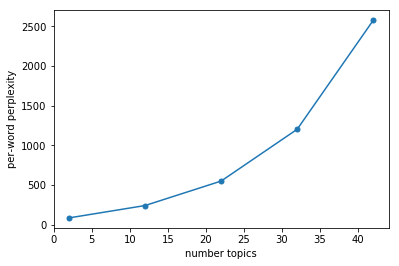

In [33]:
with open('../results/topics_perps_lists.txt','r') as infile:
    newList = json.load(infile)
    
plt.plot(newList[0], newList[1],'-o', markersize=5)
#plt.ylim([0,2000])
plt.ylabel('per-word perplexity')
plt.xlabel('number topics')
plt.show()

We see that per-word perplexity is increasing in the number of topics. After some digging around on Google, it appears that there is an issue here with gensim. Lots of people have had the same problem (for example, [article 1](https://groups.google.com/forum/#!topic/gensim/iK692kdShi4), [article2](https://groups.google.com/forum/#!topic/gensim/TpuYRxhyIOc), [article 3](http://stackoverflow.com/questions/36913218/lda-with-gensim-strange-values-for-perplexity)) and it does not appear to have been resolved. 

In light of this issue with gensim, I ignore the elbow method. I instead spent some time experimeting with different numbers of topics to find a value of k that grouped the blurbs into meaninful groups and was not so large it would make interpretation challenging. I settled on eight topics.

## Choose hyperparameter values (alpha and eta)

I had originally indended to conduct a grid search to explore how perplexity varies with different values of alpha and eta. [However, given the problems with calcuating perplexity when using gensim, I instead decided to use the deafult values of alpha and eta.]

In [ ]:
## Set number topics
k = 10

## Set the parameter values that I will search over
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5]

# Read in dictionary and corpus
my_dictionary = corpora.Dictionary.load('../Data/lda_dictionary.dict')
my_corpus = corpora.MmCorpus('../Data/lda_corpus.mm')

# Split into 80% training and 20% test sets
cp = list(my_corpus)
random.shuffle(cp)
p = int(len(cp) * .8)
cp_train = cp[0:p]
cp_test = cp[p:]

# Compute perplexities
grid_vals = {}
for alpha_val in param_list:
    perp_vals = []
    for eta_val in param_list:
        lda = gensim.models.ldamodel.LdaModel(cp_train, num_topics=k, alpha=alpha_val, eta=eta_val, id2word=my_dictionary, passes=20)
        per_word_perplex = np.exp2(-lda.log_perplexity(cp_test))
        perp_vals.append(per_word_perplex)
    grid_vals[alpha_val] = perp_vals

# Convert dictionary to DataFrame, with alpha on x axis, and eta on y axis
final_grid = pd.DataFrame(grid_vals, index=param_list)

# Write grid of perplexities to csv
final_grid.to_csv('../Results/alpha_eta_grid.csv')

## Run model with chosen parameters

I now run my chosen model.

In [ ]:
mport logging
from gensim import corpora

my_topics = 8
my_workers = 8
 
# To see output as code is running, uncomment line below
# logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.INFO)

data_directory = '../Data/'
my_dict = corpora.Dictionary.load(data_directory + 'lda_dictionary.dict')
my_corpus = corpora.MmCorpus(data_directory + 'lda_corpus.mm')

my_chunksize = int(float(len(my_corpus))/my_workers)
my_lda = gensim.models.LdaMulticore(my_corpus, num_topics=my_topics, id2word=my_dict, passes=30, workers=my_workers, chunksize=my_chunksize)
my_lda.save('../Results/lda_8topics.lda')

topic_list  = my_lda.print_topics(num_topics=my_topics, num_words=8)
for t in topic_list:
    print t[1]

I then looked at the top words for each topic (to give each topic a name) and topic proportions for each blurb (which I will use in my analysis).

In [ ]:
fin_lda = gensim.models.LdaModel.load('../aws_dir/lda_project/Results/lda_8topics.lda')

# Highest probability words in each topic
topic_list  = fin_lda.print_topics(num_topics=10, num_words=10)
for t in topic_list:
    s = t[1]
    s = ''.join([c for c in s if not (c.isdigit() or c=="*" or c=="." or c=='"')])
    print t[0], s
    print

# Topics in each blurb
for row in range(3): 
    print test_lda[corpus[row]]

Let's convert the topics for each blurb into a dataframe where each blurb is a row, and each topic colum. 

In [ ]:
topicmatrix = []
for i in range(len(corpus)):
    old_row = test_lda[corpus[i]]
    new_row = [0]*8
    for j in old_row:
        new_row[j[0]] = j[1]
    topicmatrix.append(new_row)

df = pd.DataFrame(topicmatrix)
print len(df)

## Drop columns where topic values zero
print sum(df.ix[:,6])
print sum(df.ix[:,7])
df = df.ix[:,0:5]

# Rename columns and add URN
df.columns = ['Offerings', 'Happiness', 'Inspections', 'Success', 'Support', 'Development']
df['URN'] = urn_series

# Reorder columns and reset index
df = df[['URN', 'Offerings', 'Happiness', 'Inspections', 'Success', 'Support', 'Development']]
df.reset_index(drop=True, inplace=True)

# Save
df.to_csv('../my_datasets/lda_dat.csv')

# Check df looks ok (put at end so get nice table in Jupyter)
print len(df)
df.head()

## Improving my LDA analysis

There are at least two ways in which I should like to improve my LDA analysis. First, I should like to address the issue of calculating perplexity, and find optimal values for k, alpha, and eta. Probably the best approach would be to find a different measure for evaluating the models. Perplexity would not be ideal even if it worked, as it is a measure of predictive performance, but I am not using LDA for the purposes of prediction.

Second, I should like to explore different algorithms for approximating the posterior/fitting my model. So far in training my LDA model I have only used ["online variational Bayes"](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf), the [method built into gensim](https://rare-technologies.com/multicore-lda-in-python-from-over-night-to-over-lunch/). I should like to instead try repeating my analsis with other methods, such as Gibbs sampling.  There is a wrapper in Python that should allow me to use Gibbs sampling with Gensim; however, it might instead be easier to use the LDA method in graphlab. 